In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

### Utilitarios

In [2]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

In [3]:
x_train = pd.read_csv("X_train_origin.csv")
x_valid = pd.read_csv("X_valid_origin.csv")

y_train = pd.read_csv("y_train_origin.csv")
y_valid = pd.read_csv("y_valid_origin.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((51120, 60), (12781, 60), (51120, 1), (12781, 1))

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
'Tiempo_empleo', 'Saldo_cuenta', 'Valor_prestamo', 'Impulsividad'
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Impulsividad,target
Tiempo_empleo,1.00000,0.01015,-0.00205,-0.00713,0.00186
Saldo_cuenta,0.01015,1.00000,-0.00130,0.00471,-0.00690
Valor_prestamo,-0.00205,-0.00130,1.00000,-0.00262,-0.00211
Impulsividad,-0.00713,0.00471,-0.00262,1.00000,-0.00201
target,0.00186,-0.00690,-0.00211,-0.00201,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00690
Valor_prestamo,0.00211
Impulsividad,0.00201
Tiempo_empleo,0.00186


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Tiempo_empleo,Saldo_cuenta,Valor_prestamo,Impulsividad,target
Tiempo_empleo,1.00000,0.00249,-0.00161,-0.00603,0.00096
Saldo_cuenta,0.00249,1.00000,0.00325,0.00214,-0.00791
Valor_prestamo,-0.00161,0.00325,1.00000,-0.00224,-0.00436
Impulsividad,-0.00603,0.00214,-0.00224,1.00000,-0.00219
target,0.00096,-0.00791,-0.00436,-0.00219,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00791
Valor_prestamo,0.00436
Impulsividad,0.00219
Tiempo_empleo,0.00096


In [9]:
if 'target' in x_train.columns:
    del x_train['target']

In [10]:
y_train.value_counts(normalize=True)

Incumplimiento
0                 0.858842
1                 0.141158
dtype: float64

In [11]:
len(x_train[cols_aporte].columns)

4

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold_off_on = RepeatedStratifiedKFold(
    n_splits=3, 
    n_repeats=2,
    random_state=SEED
)

param_grid_arbol = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],             
    'min_samples_split': [0.03, 0.05, 0.07, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7],
    'max_features': [0.8, 0.85, 0.9, 0.95, 1.0],
    'random_state': [SEED],
    'class_weight': ['balanced', None],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}
model_arbol = DecisionTreeClassifier(random_state=SEED)

grid_arbol = RandomizedSearchCV(
    model_arbol, 
    {k: [v] if not isinstance(v, list) else v for k, v in param_grid_arbol.items()}, 
    cv=kfold_off_on, 
    n_jobs=4, 
    scoring='roc_auc', 
    verbose=2,
    n_iter=1000,
    refit=True
)

In [13]:
#help(grid_arbol.fit)

In [14]:
%%time
grid_arbol.fit(
    x_train[cols_aporte],
    y_train,
)

best_params_arbol = grid_arbol.best_params_
score_arbol = grid_arbol.best_score_
result_2 = grid_arbol.best_estimator_

print("score: ", score_arbol)

Fitting 6 folds for each of 1000 candidates, totalling 6000 fits
score:  0.5033061872831984
Wall time: 6min 44s


In [15]:
best_params_arbol

{'splitter': 'best',
 'random_state': 29082013,
 'min_samples_split': 0.03,
 'max_features': 0.8,
 'max_depth': 5,
 'criterion': 'entropy',
 'class_weight': None,
 'ccp_alpha': 0}

In [16]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict_proba(x_train[cols_aporte])[:,1]
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict_proba(x_valid[cols_aporte])[:,1]
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [17]:
pd.Series(y_pred_class_2_train).value_counts()

0    51120
dtype: int64

In [18]:
pd.Series(y_pred_class_2_valid).value_counts()

0    12781
dtype: int64

<AxesSubplot:>

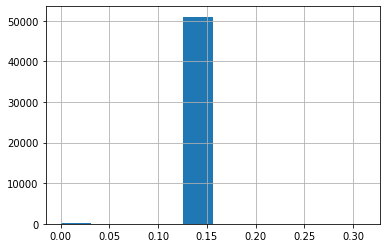

In [19]:
pd.Series(y_pred_prob_2_train).hist()

<AxesSubplot:>

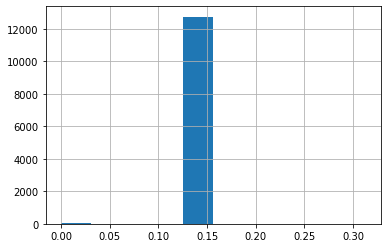

In [20]:
pd.Series(y_pred_prob_2_valid).hist()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.509
GINI: 0.018
///////////////////////// VALIDATION
AUC: 0.495
GINI: -0.011


In [22]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % accuracy_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % accuracy_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
F1 SCORE   : 0.85884194
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
F1 SCORE   : 0.85885298


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### >>> RECALL

In [23]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 5
 success: True
       x: array([0.02360338])

In [24]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.023603376913245155

In [25]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [26]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    51043
0       77
dtype: int64

In [27]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    12761
0       20
dtype: int64

In [28]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14137100
F1 SCORE   : 0.24772138
///////////////////////// VALIDATION
RECALL     : 0.99833703
EFECTIVIDAD: 0.14113314
F1 SCORE   : 0.24730518


#### >>> EFECTIVIDAD

In [29]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision 

     fun: -0.3125
 message: 'Optimization terminated successfully.'
    nfev: 92
     nit: 5
 success: True
       x: array([0.286781])

#### >>> AUC

In [30]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_auc

     fun: -0.5008769132653061
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.11725487])

In [31]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.11725487017104697

In [32]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [33]:
pd.Series(y_pred_class_train_2_auc).value_counts()

1    51043
0       77
dtype: int64

In [34]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

1    12761
0       20
dtype: int64

In [35]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14137100
F1 SCORE   : 0.24772138
F1 SCORE   : 0.14266432
///////////////////////// VALIDATION
RECALL     : 0.99833703
EFECTIVIDAD: 0.14113314
F1 SCORE   : 0.24730518
F1 SCORE   : 0.14224239
